In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [4]:
image_folder_path = '../data/refspec'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../data/refspec'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [7]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2>Keras Tuner</h2>

In [10]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):        
        inp = Input(shape=self.input_shape)
        lay = Convolution2D(filters=hp.Int('conv1', min_value=16, max_value=56, step=16, default=56),kernel_size=(7,7),strides=(2,2),padding='same')(inp)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
        lay = SpatialDropout2D(0.06)(lay)

        lay = Convolution2D(filters=hp.Int('conv2', min_value=16, max_value=72, step=16, default=72),kernel_size=(5,5),strides=(2,2),padding='same')(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
        lay = SpatialDropout2D(0.06)(lay)
        
        lay = Convolution2D(filters=hp.Int('conv3', min_value=16, max_value=56, step=16, default=56),kernel_size=(3,3),strides=(1,1),padding='same')(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
        lay = SpatialDropout2D(0.02)(lay)
        
        lay = Convolution2D(filters=hp.Int('conv4', min_value=16, max_value=72, step=16, default=72),kernel_size=(3,3),strides=(1,1),padding='same')(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
        lay = SpatialDropout2D(0.02)(lay)

        lay = Flatten()(lay)

        lay = Dense(48)(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = Dropout(0.15)(lay)

        x_out = Dense(8, name='output', activation='softmax')(lay)
        model = Model(inputs=inp, outputs=x_out)
        model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [11]:
from kerastuner.tuners import RandomSearch

hypermodel = CNNHyperModel(input_shape=(56,85,3), num_classes=8)

tuner = RandomSearch(
    hypermodel,
    objective='val_acc',
    max_trials=5,
    executions_per_trial=2,
    directory='random_search',
    project_name='bat',
    overwrite=True
)

In [12]:
tuner.search(X_train, Y_train, epochs=70, validation_split=0.1, batch_size=8, verbose=2)

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.4323 - acc: 0.5226 - val_loss: 1.1666 - val_acc: 0.6240
Epoch 2/70
2172/2172 - 2s - loss: 1.1274 - acc: 0.6146 - val_loss: 1.0816 - val_acc: 0.6612
Epoch 3/70
2172/2172 - 2s - loss: 0.9861 - acc: 0.6690 - val_loss: 0.8146 - val_acc: 0.7025
Epoch 4/70
2172/2172 - 1s - loss: 0.8206 - acc: 0.7192 - val_loss: 0.6349 - val_acc: 0.7562
Epoch 5/70
2172/2172 - 2s - loss: 0.7493 - acc: 0.7514 - val_loss: 0.6161 - val_acc: 0.7810
Epoch 6/70
2172/2172 - 2s - loss: 0.6686 - acc: 0.7698 - val_loss: 0.5079 - val_acc: 0.8058
Epoch 7/70
2172/2172 - 2s - loss: 0.5797 - acc: 0.8034 - val_loss: 0.4629 - val_acc: 0.8306
Epoch 8/70
2172/2172 - 2s - loss: 0.5699 - acc: 0.8043 - val_loss: 0.4071 - val_acc: 0.8471
Epoch 9/70
2172/2172 - 1s - loss: 0.4786 - acc: 0.8356 - val_loss: 0.4566 - val_acc: 0.8347
Epoch 10/70
2172/2172 - 2s - loss: 0.4735 - acc: 0.8278 - val_loss: 0.3567 - val_acc: 0.8719
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.3147 - acc: 0.8881 - val_loss: 0.2367 - val_acc: 0.9174
Epoch 20/70
2172/2172 - 2s - loss: 0.3005 - acc: 0.9010 - val_loss: 0.2341 - val_acc: 0.9008
Epoch 21/70
2172/2172 - 2s - loss: 0.2907 - acc: 0.9010 - val_loss: 0.1968 - val_acc: 0.9174
Epoch 22/70
2172/2172 - 2s - loss: 0.2719 - acc: 0.9075 - val_loss: 0.1736 - val_acc: 0.9421
Epoch 23/70
2172/2172 - 2s - loss: 0.2840 - acc: 0.9033 - val_loss: 0.2330 - val_acc: 0.9091
Epoch 24/70
2172/2172 - 2s - loss: 0.2597 - acc: 0.9121 - val_loss: 0.1518 - val_acc: 0.9504
Epoch 25/70
2172/2172 - 2s - loss: 0.2793 - acc: 0.9061 - val_loss: 0.2165 - val_acc: 0.9174
Epoch 26/70
2172/2172 - 2s - loss: 0.2306 - acc: 0.9231 - val_loss: 0.1458 - val_acc: 0.9421
Epoch 27/70
2172/2172 - 2s - loss: 0.2518 - acc: 0.9208 - val_loss: 0.1723 - val_acc: 0.9421
Epoch 28/70
2172/2172 - 2s - loss: 0.2329 - acc: 0.9231 - val_loss: 0.1673 - val_acc: 0.9463
Epoch 29/70
2172/2172 - 2s - loss: 0.2343 - acc: 0.9139 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 2s - loss: 1.4426 - acc: 0.5382 - val_loss: 1.1389 - val_acc: 0.6694
Epoch 2/70
2172/2172 - 2s - loss: 1.1902 - acc: 0.5921 - val_loss: 1.2361 - val_acc: 0.5165
Epoch 3/70
2172/2172 - 2s - loss: 1.0058 - acc: 0.6579 - val_loss: 0.9770 - val_acc: 0.6322
Epoch 4/70
2172/2172 - 2s - loss: 0.8490 - acc: 0.7284 - val_loss: 0.6198 - val_acc: 0.7521
Epoch 5/70
2172/2172 - 2s - loss: 0.7521 - acc: 0.7560 - val_loss: 0.5942 - val_acc: 0.7851
Epoch 6/70
2172/2172 - 2s - loss: 0.6504 - acc: 0.7804 - val_loss: 0.4693 - val_acc: 0.8264
Epoch 7/70
2172/2172 - 2s - loss: 0.6023 - acc: 0.7928 - val_loss: 0.4996 - val_acc: 0.8140
Epoch 8/70
2172/2172 - 2s - loss: 0.5404 - acc: 0.8089 - val_loss: 0.3879 - val_acc: 0.8430
Epoch 9/70
2172/2172 - 2s - loss: 0.5127 - acc: 0.8237 - val_loss: 0.3855 - val_acc: 0.8554
Epoch 10/70
2172/2172 - 2s - loss: 0.4829 - acc: 0.8329 - val_loss: 0.3073 - val_acc: 0.8802
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.3083 - acc: 0.8872 - val_loss: 0.2466 - val_acc: 0.9091
Epoch 20/70
2172/2172 - 2s - loss: 0.3127 - acc: 0.8890 - val_loss: 0.1918 - val_acc: 0.9339
Epoch 21/70
2172/2172 - 2s - loss: 0.2819 - acc: 0.9006 - val_loss: 0.3508 - val_acc: 0.8678
Epoch 22/70
2172/2172 - 2s - loss: 0.2689 - acc: 0.9079 - val_loss: 0.1784 - val_acc: 0.9339
Epoch 23/70
2172/2172 - 2s - loss: 0.2612 - acc: 0.9088 - val_loss: 0.1875 - val_acc: 0.9421
Epoch 24/70
2172/2172 - 2s - loss: 0.2457 - acc: 0.9180 - val_loss: 0.1649 - val_acc: 0.9380
Epoch 25/70
2172/2172 - 1s - loss: 0.2155 - acc: 0.9245 - val_loss: 0.1248 - val_acc: 0.9587
Epoch 26/70
2172/2172 - 2s - loss: 0.2125 - acc: 0.9250 - val_loss: 0.1660 - val_acc: 0.9463
Epoch 27/70
2172/2172 - 2s - loss: 0.2377 - acc: 0.9213 - val_loss: 0.1128 - val_acc: 0.9669
Epoch 28/70
2172/2172 - 1s - loss: 0.2240 - acc: 0.9254 - val_loss: 0.1769 - val_acc: 0.9504
Epoch 29/70
2172/2172 - 2s - loss: 0.2002 - acc: 0.9291 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 2s - loss: 1.3838 - acc: 0.5483 - val_loss: 1.1068 - val_acc: 0.6405
Epoch 2/70
2172/2172 - 2s - loss: 1.2035 - acc: 0.5916 - val_loss: 1.1329 - val_acc: 0.6736
Epoch 3/70
2172/2172 - 2s - loss: 1.0140 - acc: 0.6524 - val_loss: 0.7911 - val_acc: 0.7025
Epoch 4/70
2172/2172 - 2s - loss: 0.8802 - acc: 0.6994 - val_loss: 0.7481 - val_acc: 0.7479
Epoch 5/70
2172/2172 - 2s - loss: 0.7942 - acc: 0.7307 - val_loss: 0.6297 - val_acc: 0.7355
Epoch 6/70
2172/2172 - 2s - loss: 0.7040 - acc: 0.7610 - val_loss: 0.5212 - val_acc: 0.8223
Epoch 7/70
2172/2172 - 2s - loss: 0.6014 - acc: 0.7993 - val_loss: 0.4269 - val_acc: 0.8306
Epoch 8/70
2172/2172 - 2s - loss: 0.5641 - acc: 0.8126 - val_loss: 0.5391 - val_acc: 0.8058
Epoch 9/70
2172/2172 - 2s - loss: 0.5178 - acc: 0.8297 - val_loss: 0.4486 - val_acc: 0.8306
Epoch 10/70
2172/2172 - 2s - loss: 0.4569 - acc: 0.8462 - val_loss: 0.3603 - val_acc: 0.8719
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.3080 - acc: 0.8950 - val_loss: 0.2546 - val_acc: 0.9174
Epoch 20/70
2172/2172 - 2s - loss: 0.2734 - acc: 0.9029 - val_loss: 0.2103 - val_acc: 0.9215
Epoch 21/70
2172/2172 - 2s - loss: 0.2693 - acc: 0.9157 - val_loss: 0.2423 - val_acc: 0.9298
Epoch 22/70
2172/2172 - 2s - loss: 0.2791 - acc: 0.8987 - val_loss: 0.1991 - val_acc: 0.9256
Epoch 23/70
2172/2172 - 2s - loss: 0.2647 - acc: 0.9102 - val_loss: 0.1721 - val_acc: 0.9339
Epoch 24/70
2172/2172 - 2s - loss: 0.2492 - acc: 0.9116 - val_loss: 0.1848 - val_acc: 0.9256
Epoch 25/70
2172/2172 - 2s - loss: 0.2778 - acc: 0.9042 - val_loss: 0.4483 - val_acc: 0.8595
Epoch 26/70
2172/2172 - 2s - loss: 0.2231 - acc: 0.9254 - val_loss: 0.3255 - val_acc: 0.8884
Epoch 27/70
2172/2172 - 2s - loss: 0.2259 - acc: 0.9240 - val_loss: 0.2158 - val_acc: 0.9174
Epoch 28/70
2172/2172 - 2s - loss: 0.2246 - acc: 0.9250 - val_loss: 0.3392 - val_acc: 0.9091
Epoch 29/70
2172/2172 - 2s - loss: 0.2300 - acc: 0.9240 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 2s - loss: 1.4896 - acc: 0.5037 - val_loss: 1.2800 - val_acc: 0.6446
Epoch 2/70
2172/2172 - 1s - loss: 1.1808 - acc: 0.5999 - val_loss: 1.1262 - val_acc: 0.5413
Epoch 3/70
2172/2172 - 2s - loss: 0.9381 - acc: 0.6865 - val_loss: 0.8507 - val_acc: 0.6736
Epoch 4/70
2172/2172 - 2s - loss: 0.8380 - acc: 0.7205 - val_loss: 0.5893 - val_acc: 0.7727
Epoch 5/70
2172/2172 - 2s - loss: 0.7214 - acc: 0.7555 - val_loss: 0.5262 - val_acc: 0.7893
Epoch 6/70
2172/2172 - 2s - loss: 0.6751 - acc: 0.7818 - val_loss: 0.4796 - val_acc: 0.7934
Epoch 7/70
2172/2172 - 2s - loss: 0.5628 - acc: 0.8052 - val_loss: 0.4882 - val_acc: 0.8182
Epoch 8/70
2172/2172 - 2s - loss: 0.5649 - acc: 0.8029 - val_loss: 0.3940 - val_acc: 0.8430
Epoch 9/70
2172/2172 - 2s - loss: 0.5046 - acc: 0.8287 - val_loss: 0.3742 - val_acc: 0.8760
Epoch 10/70
2172/2172 - 2s - loss: 0.5024 - acc: 0.8320 - val_loss: 0.3693 - val_acc: 0.8512
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.3117 - acc: 0.8950 - val_loss: 0.2339 - val_acc: 0.9215
Epoch 20/70
2172/2172 - 2s - loss: 0.2861 - acc: 0.9024 - val_loss: 0.2803 - val_acc: 0.8884
Epoch 21/70
2172/2172 - 2s - loss: 0.2782 - acc: 0.9019 - val_loss: 0.3461 - val_acc: 0.8802
Epoch 22/70
2172/2172 - 2s - loss: 0.2618 - acc: 0.9121 - val_loss: 0.1114 - val_acc: 0.9669
Epoch 23/70
2172/2172 - 2s - loss: 0.2923 - acc: 0.8987 - val_loss: 0.2422 - val_acc: 0.8967
Epoch 24/70
2172/2172 - 2s - loss: 0.2642 - acc: 0.9038 - val_loss: 0.2738 - val_acc: 0.8967
Epoch 25/70
2172/2172 - 2s - loss: 0.2577 - acc: 0.9084 - val_loss: 0.1704 - val_acc: 0.9380
Epoch 26/70
2172/2172 - 2s - loss: 0.2389 - acc: 0.9134 - val_loss: 0.1746 - val_acc: 0.9421
Epoch 27/70
2172/2172 - 2s - loss: 0.2396 - acc: 0.9180 - val_loss: 0.1812 - val_acc: 0.9298
Epoch 28/70
2172/2172 - 2s - loss: 0.2420 - acc: 0.9139 - val_loss: 0.1440 - val_acc: 0.9298
Epoch 29/70
2172/2172 - 2s - loss: 0.2168 - acc: 0.9231 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 2s - loss: 1.4028 - acc: 0.5479 - val_loss: 1.1370 - val_acc: 0.6281
Epoch 2/70
2172/2172 - 2s - loss: 1.2466 - acc: 0.5930 - val_loss: 1.0936 - val_acc: 0.6198
Epoch 3/70
2172/2172 - 2s - loss: 1.0993 - acc: 0.6238 - val_loss: 1.0453 - val_acc: 0.6777
Epoch 4/70
2172/2172 - 2s - loss: 0.9345 - acc: 0.6860 - val_loss: 0.6805 - val_acc: 0.7562
Epoch 5/70
2172/2172 - 2s - loss: 0.7947 - acc: 0.7265 - val_loss: 0.6651 - val_acc: 0.7851
Epoch 6/70
2172/2172 - 2s - loss: 0.7064 - acc: 0.7528 - val_loss: 0.8333 - val_acc: 0.6736
Epoch 7/70
2172/2172 - 2s - loss: 0.6416 - acc: 0.7799 - val_loss: 0.4454 - val_acc: 0.8430
Epoch 8/70
2172/2172 - 2s - loss: 0.5387 - acc: 0.8122 - val_loss: 0.4715 - val_acc: 0.8264
Epoch 9/70
2172/2172 - 2s - loss: 0.4969 - acc: 0.8283 - val_loss: 0.4096 - val_acc: 0.8306
Epoch 10/70
2172/2172 - 2s - loss: 0.4606 - acc: 0.8425 - val_loss: 0.4785 - val_acc: 0.8223
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.3145 - acc: 0.8886 - val_loss: 0.2367 - val_acc: 0.9091
Epoch 20/70
2172/2172 - 2s - loss: 0.3185 - acc: 0.8895 - val_loss: 0.3116 - val_acc: 0.9091
Epoch 21/70
2172/2172 - 2s - loss: 0.3052 - acc: 0.8973 - val_loss: 0.2390 - val_acc: 0.9091
Epoch 22/70
2172/2172 - 2s - loss: 0.2774 - acc: 0.9042 - val_loss: 0.1953 - val_acc: 0.9132
Epoch 23/70
2172/2172 - 2s - loss: 0.2519 - acc: 0.9121 - val_loss: 0.1527 - val_acc: 0.9545
Epoch 24/70
2172/2172 - 2s - loss: 0.2361 - acc: 0.9180 - val_loss: 0.1628 - val_acc: 0.9463
Epoch 25/70
2172/2172 - 2s - loss: 0.2636 - acc: 0.9130 - val_loss: 0.2904 - val_acc: 0.9256
Epoch 26/70
2172/2172 - 2s - loss: 0.2266 - acc: 0.9282 - val_loss: 0.1762 - val_acc: 0.9380
Epoch 27/70
2172/2172 - 2s - loss: 0.2412 - acc: 0.9157 - val_loss: 0.1980 - val_acc: 0.9091
Epoch 28/70
2172/2172 - 2s - loss: 0.2124 - acc: 0.9286 - val_loss: 0.1743 - val_acc: 0.9380
Epoch 29/70
2172/2172 - 2s - loss: 0.2118 - acc: 0.9296 - val_loss: 0.

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

In [14]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, Y_test)

604/604 [==============================] - ETA: 1s - loss: 0.0834 - acc: 0.968 - 0s 234us/sample - loss: 0.1325 - acc: 0.9553


In [15]:
accuracy

0.955298

In [16]:
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 85, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 43, 48)        7104      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 43, 48)        192       
_________________________________________________________________
activation (Activation)      (None, 28, 43, 48)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 22, 48)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 14, 22, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 11, 32)         38432 

<h2>Evaluate Best Model</h2>

In [17]:
model = best_model

[[  5   0   0   0   0   0   0   0]
 [  0  25   0   0   0   0   0   0]
 [  0   0  21   1   0   0   0   0]
 [  0   0   1  56   0   2   0   1]
 [  0   1   0   2 327   0   0   3]
 [  0   1   0   3   0  50   0   0]
 [  0   2   2   0   5   0  15   0]
 [  0   0   0   1   1   0   1  78]]


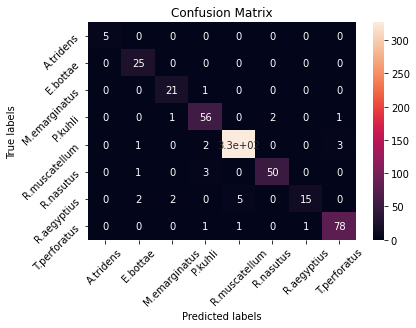

In [18]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [19]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9552980132450332


In [20]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

               precision    recall  f1-score   support

    A.tridens       1.00      1.00      1.00         5
     E.bottae       0.86      1.00      0.93        25
M.emarginatus       0.88      0.95      0.91        22
      P.kuhli       0.89      0.93      0.91        60
R.muscatellum       0.98      0.98      0.98       333
    R.nasutus       0.96      0.93      0.94        54
  R.aegyptius       0.94      0.62      0.75        24
 T.perforatus       0.95      0.96      0.96        81

     accuracy                           0.96       604
    macro avg       0.93      0.92      0.92       604
 weighted avg       0.96      0.96      0.95       604



<h2>K-Fold Training and Evaluation</h2>

In [8]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [9]:
model = build_current_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 85, 56)        224       
_________________________________________________________________
activation (Activation)      (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 43, 56)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 28, 43, 56)        0         
_________

In [10]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_history = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=70,
              validation_split=0.1,
              verbose=2)
    
    all_history.append(history)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.3937 - acc: 0.5483 - val_loss: 1.2285 - val_acc: 0.6157
Epoch 2/70
2172/2172 - 2s - loss: 1.2109 - acc: 0.6022 - val_loss: 1.1709 - val_acc: 0.6116
Epoch 3/70
2172/2172 - 2s - loss: 1.0848 - acc: 0.6321 - val_loss: 1.0721 - val_acc: 0.6322
Epoch 4/70
2172/2172 - 2s - loss: 0.9556 - acc: 0.6819 - val_loss: 0.8854 - val_acc: 0.7149
Epoch 5/70
2172/2172 - 2s - loss: 0.8694 - acc: 0.7099 - val_loss: 0.8409 - val_acc: 0.6942
Epoch 6/70
2172/2172 - 2s - loss: 0.7984 - acc: 0.7380 - val_loss: 0.6604 - val_acc: 0.7727
Epoch 7/70
2172/2172 - 2s - loss: 0.6551 - acc: 0.7919 - val_loss: 0.6527 - val_acc: 0.8306
Epoch 8/70
2172/2172 - 2s - loss: 0.5901 - acc: 0.8122 - val_loss: 0.6150 - val_acc: 0.8017
Epoch 9/70
2172/2172 - 2s - loss: 0.5197 - acc: 0.8320 - val_loss: 0.3943 - val_acc: 0.8554
Epoch 10/70
2172/2172 - 2s - loss: 0.4752 - acc: 0.8485 - val_loss: 0.3604 - val_acc: 0.8595
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.2718 - acc: 0.9121 - val_loss: 0.2437 - val_acc: 0.9215
Epoch 20/70
2172/2172 - 2s - loss: 0.2387 - acc: 0.9217 - val_loss: 0.1958 - val_acc: 0.9421
Epoch 21/70
2172/2172 - 2s - loss: 0.2095 - acc: 0.9291 - val_loss: 0.1530 - val_acc: 0.9545
Epoch 22/70
2172/2172 - 2s - loss: 0.2468 - acc: 0.9167 - val_loss: 0.1748 - val_acc: 0.9545
Epoch 23/70
2172/2172 - 2s - loss: 0.2117 - acc: 0.9277 - val_loss: 0.1402 - val_acc: 0.9504
Epoch 24/70
2172/2172 - 3s - loss: 0.1887 - acc: 0.9374 - val_loss: 0.1305 - val_acc: 0.9463
Epoch 25/70
2172/2172 - 2s - loss: 0.1840 - acc: 0.9351 - val_loss: 0.1793 - val_acc: 0.9256
Epoch 26/70
2172/2172 - 2s - loss: 0.1680 - acc: 0.9424 - val_loss: 0.1395 - val_acc: 0.9545
Epoch 27/70
2172/2172 - 2s - loss: 0.2110 - acc: 0.9305 - val_loss: 0.1458 - val_acc: 0.9545
Epoch 28/70
2172/2172 - 2s - loss: 0.1659 - acc: 0.9498 - val_loss: 0.4028 - val_acc: 0.8471
Epoch 29/70
2172/2172 - 3s - loss: 0.1668 - acc: 0.9429 - val_loss: 0.

Epoch 37/70
2172/2172 - 3s - loss: 0.1419 - acc: 0.9544 - val_loss: 0.1707 - val_acc: 0.9421
Epoch 38/70
2172/2172 - 3s - loss: 0.1199 - acc: 0.9590 - val_loss: 0.1476 - val_acc: 0.9587
Epoch 39/70
2172/2172 - 3s - loss: 0.1216 - acc: 0.9526 - val_loss: 0.1098 - val_acc: 0.9628
Epoch 40/70
2172/2172 - 3s - loss: 0.1349 - acc: 0.9576 - val_loss: 0.0772 - val_acc: 0.9752
Epoch 41/70
2172/2172 - 3s - loss: 0.0870 - acc: 0.9701 - val_loss: 0.0979 - val_acc: 0.9669
Epoch 42/70
2172/2172 - 3s - loss: 0.1080 - acc: 0.9669 - val_loss: 0.1333 - val_acc: 0.9669
Epoch 43/70
2172/2172 - 3s - loss: 0.0959 - acc: 0.9696 - val_loss: 0.0595 - val_acc: 0.9752
Epoch 44/70
2172/2172 - 3s - loss: 0.0988 - acc: 0.9641 - val_loss: 0.1596 - val_acc: 0.9504
Epoch 45/70
2172/2172 - 3s - loss: 0.1117 - acc: 0.9636 - val_loss: 0.0769 - val_acc: 0.9711
Epoch 46/70
2172/2172 - 3s - loss: 0.0830 - acc: 0.9710 - val_loss: 0.1987 - val_acc: 0.9421
Epoch 47/70
2172/2172 - 3s - loss: 0.1018 - acc: 0.9692 - val_loss: 0.

Epoch 55/70
2173/2173 - 2s - loss: 0.0787 - acc: 0.9761 - val_loss: 0.1104 - val_acc: 0.9669
Epoch 56/70
2173/2173 - 2s - loss: 0.0602 - acc: 0.9807 - val_loss: 0.1165 - val_acc: 0.9545
Epoch 57/70
2173/2173 - 2s - loss: 0.0523 - acc: 0.9867 - val_loss: 0.0954 - val_acc: 0.9504
Epoch 58/70
2173/2173 - 2s - loss: 0.0748 - acc: 0.9738 - val_loss: 0.0968 - val_acc: 0.9628
Epoch 59/70
2173/2173 - 2s - loss: 0.0764 - acc: 0.9751 - val_loss: 0.0788 - val_acc: 0.9711
Epoch 60/70
2173/2173 - 2s - loss: 0.0630 - acc: 0.9788 - val_loss: 0.2127 - val_acc: 0.9380
Epoch 61/70
2173/2173 - 2s - loss: 0.0631 - acc: 0.9807 - val_loss: 0.1011 - val_acc: 0.9793
Epoch 62/70
2173/2173 - 2s - loss: 0.0321 - acc: 0.9894 - val_loss: 0.0577 - val_acc: 0.9793
Epoch 63/70
2173/2173 - 2s - loss: 0.0335 - acc: 0.9917 - val_loss: 0.0866 - val_acc: 0.9876
Epoch 64/70
2173/2173 - 2s - loss: 0.1097 - acc: 0.9669 - val_loss: 0.2544 - val_acc: 0.9256
Epoch 65/70
2173/2173 - 2s - loss: 0.0740 - acc: 0.9747 - val_loss: 0.

In [11]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.95133333 0.913794   0.95319416 0.98256367 0.96917338
 0.79604827 0.92394413]
precision sdev by class [0.         0.03066667 0.05145982 0.02436406 0.00666235 0.01905199
 0.10374681 0.06417323]
macro precision mean 0.9362563664821468
macro precision sdev 0.021637551091796124
recall mean [0.92       0.94333333 0.81225296 0.91327684 0.98078078 0.91830887
 0.92533333 0.97015432]
recall sdev [0.16       0.02043961 0.07322394 0.06176022 0.00902901 0.03799147
 0.04882395 0.01702451]
macro recall mean 0.9229300554916025
macro recall sdev 0.033884510275765126
f1 mean [0.95       0.9472517  0.85679403 0.9308734  0.98165568 0.94242441
 0.85133178 0.9455673 ]
f1 sdev [0.1        0.02469422 0.04072691 0.02391373 0.00689083 0.01931384
 0.06138319 0.03913578]
macro f1 mean 0.9257372882119259
macro f1 sdev 0.028658213198882752
accuracy mean 0.9565862739283715
accuracy sdev 0.015505232602027389


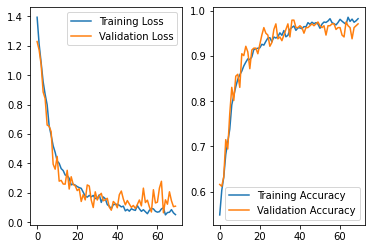

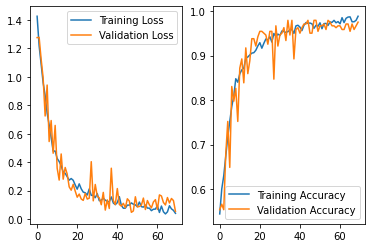

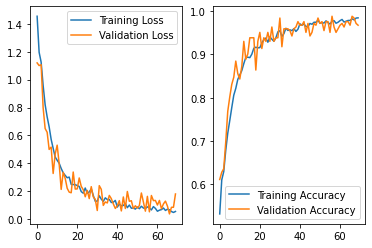

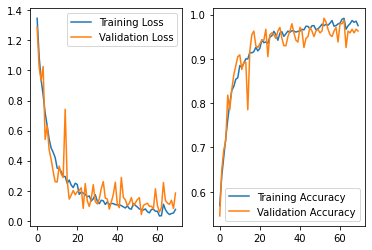

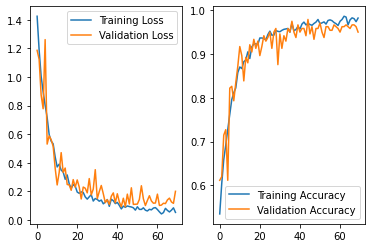

In [17]:
# Plot train val graphs
for i in range(n_split):
    _, axs = plt.subplots(ncols=2)
    df_history_info = pd.DataFrame(all_history[i].history) 


    sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df_history_info['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df_history_info['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

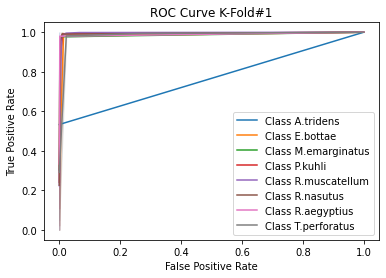

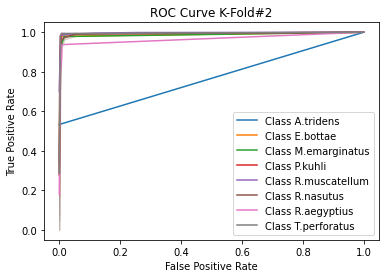

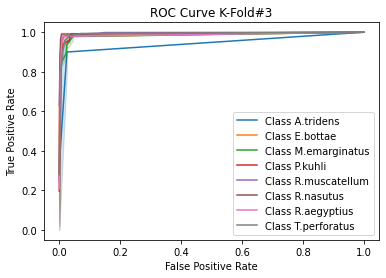

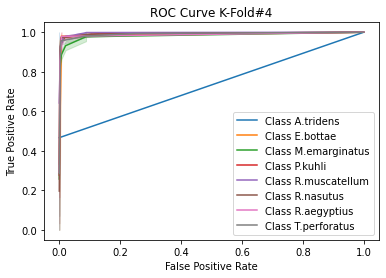

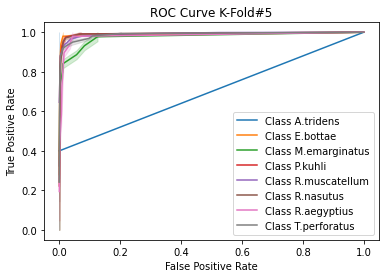

In [20]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')
        

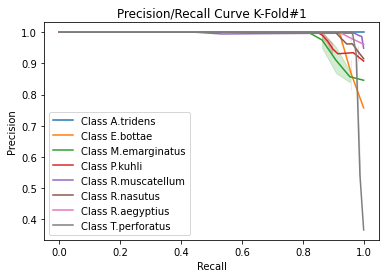

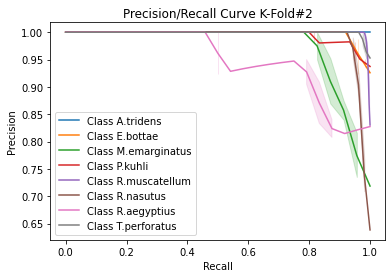

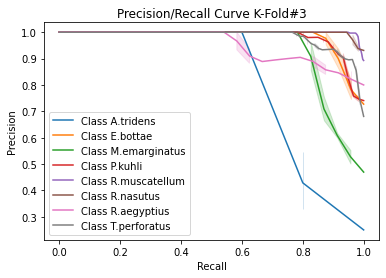

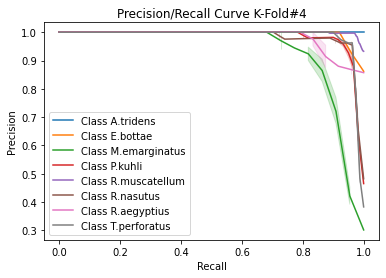

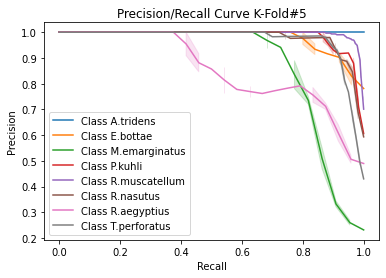

In [19]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  5   0   0   0   0   0   0   0]
 [  0  24   0   0   1   0   0   0]
 [  0   0  20   0   1   0   1   0]
 [  0   0   1  58   0   0   0   0]
 [  0   0   1   0 331   0   0   1]
 [  0   0   0   4   0  50   0   0]
 [  0   0   1   0   0   0  24   0]
 [  0   0   0   0   2   0   0  79]]


Confusion Matrix K-Fold #2

[[  5   0   0   0   0   0   0   0]
 [  0  24   0   0   0   1   0   0]
 [  0   0  19   1   2   0   1   0]
 [  0   0   0  57   0   2   0   1]
 [  0   0   0   1 329   0   2   1]
 [  0   1   0   1   0  50   1   0]
 [  0   0   0   0   3   0  21   0]
 [  0   0   0   0   1   0   0  80]]


Confusion Matrix K-Fold #3

[[  3   0   0   0   0   0   2   0]
 [  0  22   0   0   1   0   0   1]
 [  0   0  19   0   1   0   2   1]
 [  0   0   1  49   0   1   0   9]
 [  0   0   1   0 326   1   0   5]
 [  0   2   0   0   0  52   0   0]
 [  0   0   0   1   2   0  21   0]
 [  0   0   0   0   1   0   1  79]]


Confusion Matrix K-Fold #4

[[  5   0   0   0   0   0   0   0]
 [  

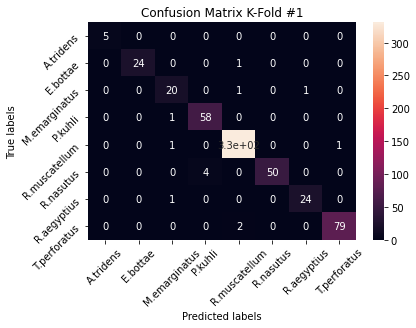

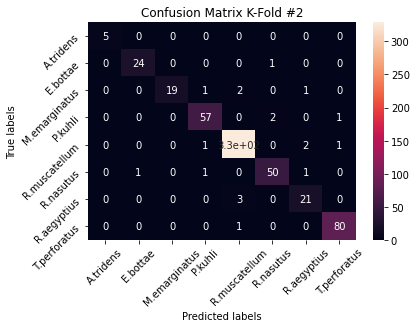

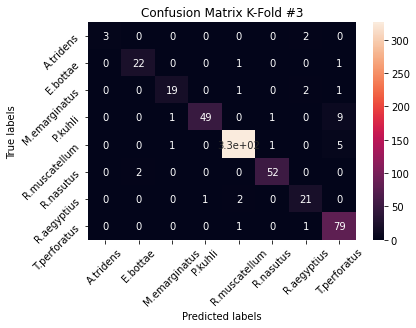

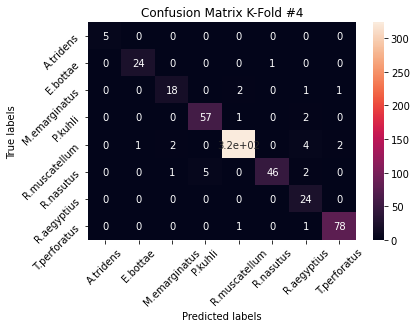

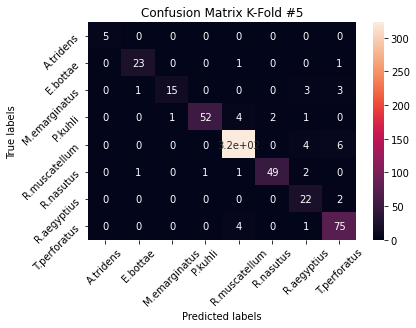

In [21]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  23    0    0    0    0    0    2    0]
 [   0  117    0    0    3    2    0    2]
 [   0    1   91    1    6    0    8    5]
 [   0    0    3  273    5    5    3   10]
 [   0    1    4    1 1633    1   10   15]
 [   0    4    1   11    1  247    5    0]
 [   0    0    1    1    5    0  112    2]
 [   0    0    0    0    9    0    3  391]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  23   0   0   0   0   0   0]
 [  0   0  18   0   1   0   1   1]
 [  0   0   0  54   1   1   0   2]
 [  0   0   0   0 326   0   2   3]
 [  0   0   0   2   0  49   1   0]
 [  0   0   0   0   1   0  22   0]
 [  0   0   0   0   1   0   0  78]]


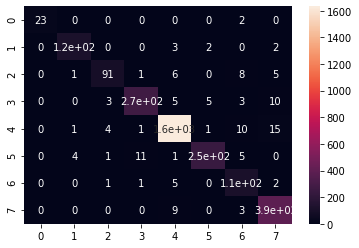

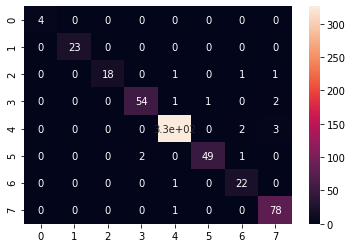

In [22]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.92 0.   0.   0.   0.   0.   0.08 0.  ]
 [0.   0.94 0.   0.   0.02 0.02 0.   0.02]
 [0.   0.01 0.81 0.01 0.05 0.   0.07 0.04]
 [0.   0.   0.01 0.91 0.02 0.02 0.01 0.03]
 [0.   0.   0.   0.   0.98 0.   0.01 0.01]
 [0.   0.01 0.   0.04 0.   0.92 0.02 0.  ]
 [0.   0.   0.01 0.01 0.04 0.   0.93 0.02]
 [0.   0.   0.   0.   0.02 0.   0.01 0.97]]


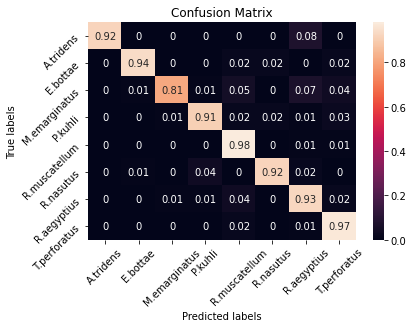

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2>Storing/Loading history and model to file</h2>

In [23]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'Model2-P-bats.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [25]:
#Load History 
history_info = pd.read_json('Model2-P-bats.json')

In [26]:
##Save Model
model.save('Model2-P-bats_trained.model') #Save the model

In [27]:
## Load Model
model = tf.keras.models.load_model('Model2V2-bats_trained.model') #Re load model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
